In [1]:
import utilities
import features
import librosa
import matplotlib.pyplot as plt
import numpy as np
import mir_eval
import pitchspace

Chromagram evaluation with beat-tracking </br>
-> CRP chroma

/home/max/.local/lib/python3.10/site-packages/madmom/features/downbeats.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best = np.argmax(np.asarray(results)[:, 1])


(0.0, 20.0)

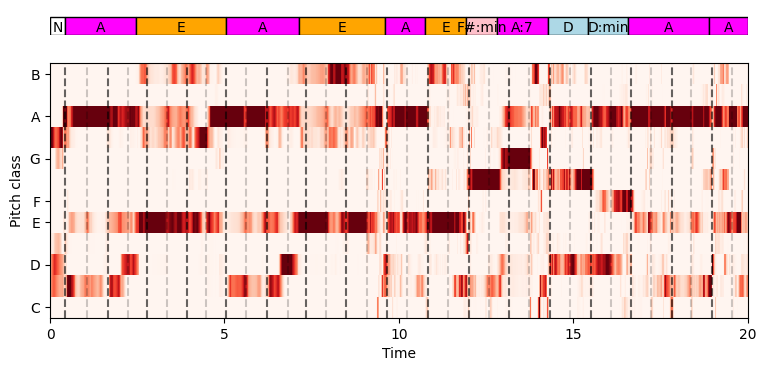

In [3]:
start = 0
stop = 20
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/"
title = "06_-_Rubber_Soul/11_-_In_My_Life"
# title = "12_-_Let_It_Be/06_-_Let_It_Be"
# title = "10CD1_-_The_Beatles/CD1_-_17_-_Julia"

y,sr = librosa.load(path+"/audio/"+title+".wav",mono=True,offset=start,duration=stop-start,sr=22050)
target = mir_eval.io.load_labeled_intervals(path+"/annotations/chordlab/The Beatles/"+title+".lab",' ','#')

t, chroma = features.crpChroma(y,nCRP=22)
beattracking = True
try:
    if beattracking and not downbeats:
        downbeats, upbeats = features.madmom_beats(path+"/audio/"+title+".wav",2)
except NameError:
    downbeats, upbeats = features.madmom_beats(path+"/audio/"+title+".wav",2)
fig,ax = plt.subplots(2,1,height_ratios=(1,10),figsize=(9,4))
utilities.plotChordAnnotations(ax[0],target,(start,stop))
utilities.plotChromagram(ax[1],t,chroma,downbeats,upbeats);
ax[1].set_xlim(start,stop)

Complexity features

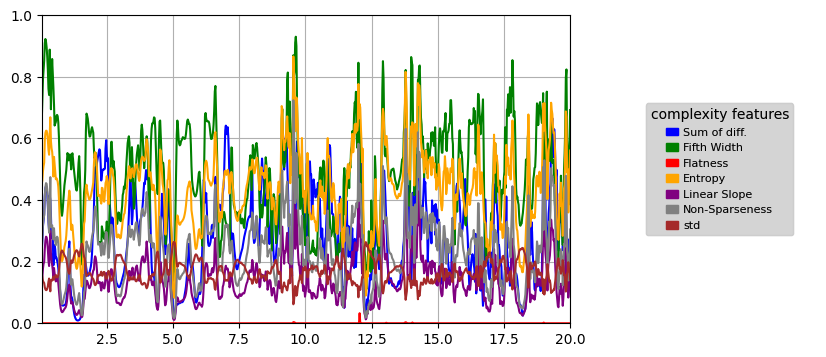

In [72]:
complexity_features = [
                features.sumChromaDifferences(chroma),
                features.angularDeviation(chroma),
                features.flatness(chroma),
                features.shannonEntropy(chroma),
                features.negativeSlope(chroma),
                features.nonSparseness(chroma),
                features.standardDeviation(chroma)
]
fig,ax = plt.subplots(1,2,width_ratios=(7.5,2.5),figsize=(10,4))
utilities.plotComplexityFeatures(ax[0],ax[1],t,complexity_features)


Key estimation with the pitch space


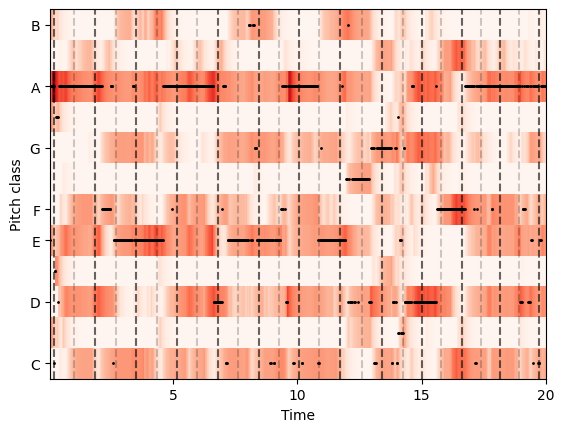

In [73]:
pc_energy = pitchspace.getPitchClassEnergyProfile(chroma,threshold=0.7,angle_weight=0.7)
pc_energy_filtered = pitchspace.filterPitchClassEnergy(pc_energy,alpha=0.9)
keys = np.argmax(pc_energy,axis=1)
fig,ax = plt.subplots()
# pitch class energy can conveniently be visualized with the plotChromagram function
utilities.plotChromagram(ax,t,pc_energy_filtered,downbeats,upbeats)
ax.plot(t,keys,'ok',markersize=1)


Chord estimation with pitch space with a given Chromagram